# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## <font color='red'>VERY IMPORTANT: if some of the following instructions is not followed, it will be penalized</font>

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 27th of november at 21:55**, using the **moodle platform**.
- Only **one submission by pair** of students
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "alexis"
ln1 = "gerbeaux"
fn2 = "manon"
ln2 = "rivoire"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_gerbeaux_alexis_and_rivoire_manon.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[0. Test Numba](#numba)<br>
[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [0]:
%matplotlib inline

In [0]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import numba # available at: http://numba.pydata.org/numba-doc/latest/user/installing.html
from numba import njit

In [0]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [5]:
print(numba.__version__) # Your version of Numba

0.40.1


In [0]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
go_fast(x); # Running a first time the function to compile it

Iteration time of the Numba-compiled function.

In [7]:
%timeit go_fast(x)

The slowest run took 29.27 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 902 ns per loop


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [8]:
%timeit go_fast.py_func(x)

The slowest run took 7.92 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 21.6 µs per loop


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [0]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [0]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [0]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [0]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [0]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model (our solutions will not converge to this one!)
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


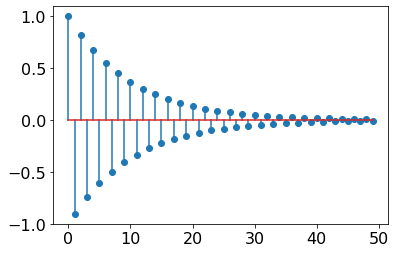

In [14]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [15]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

3.093732128901403e-06

In [16]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

2.830164088380232e-07

### Choice of the model

In [0]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [18]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.0628866434062625


### Get a very precise minimum to compute distances to minimum

In [19]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(x_min) #best solution to the opti pb. We will compare our others minimizers to this one assuming it's the 'real' solution
print(norm(grad(x_min, A, b, lbda)))

0.5242497077032731
[ 0.8998483  -0.71991981  0.68109136 -0.65310384  0.56605978 -0.52373574
  0.47785741 -0.41830517  0.40852528 -0.37084092  0.29576847 -0.27923273
  0.29163895 -0.24707563  0.19427299 -0.17340236  0.15664246 -0.13657214
  0.12026351 -0.13108037  0.14776961 -0.14509335  0.09208174 -0.08071591
  0.11368268 -0.06765796  0.06939173 -0.08487678  0.07264072 -0.05531767
  0.03474751 -0.01743271  0.02787594 -0.06386234  0.04253284 -0.04545181
  0.03113483 -0.05347387  0.03907165  0.03041819  0.0073103  -0.06621549
  0.09521816 -0.04902975 -0.01728647  0.02917645 -0.03021575  0.00740828
 -0.01878895  0.03084791]
5.97348062954797e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [0]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [0]:
# Number of full batch iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q1) Fill in the iteration of the GD solver in the cell below

In [0]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    A, b, lbda = args
    n, d = A.shape
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = x - step*grad(x, A, b, lbda)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
step = 1. / lipschitz_constant(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q2) Fill in the iteration of the AGD solver in the cell below

In [0]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    A, b, lbda = args
    n, d = A.shape
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new = y - step*grad(y, A, b, lbda)
        t_new = 0.5*(1+np.sqrt(1+4*t**2))
        y = x_new + (x_new-x)*(t-1)/t_new
        x = x_new
        t = t_new
        ### END TODO
    return x, x_list

In [0]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [0]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [0]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [0]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

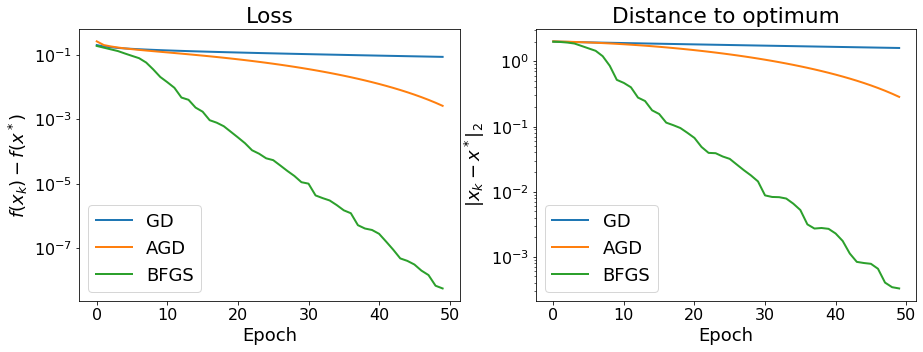

In [29]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs]

solvers = ["GD", "AGD", "BFGS"]

plot_epochs(monitors, solvers)

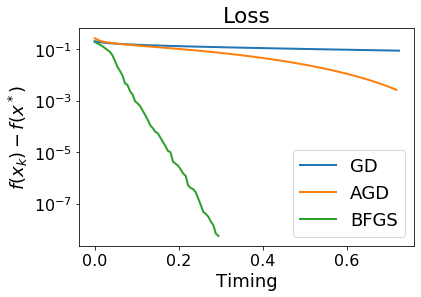

In [30]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q3) Give some first conclusions about the batch solver studied here 

- Q4) What do you observe about AGD? is it suprising ?


*ANSWERS*:
- Q3) 
#### Results For Linear Regression 
We can observe that both the GD and the AGD methods have low performances with regards to the BFGS method. <br/>
Indeed, concerning the GD method, the loss function with regards to the number of epochs or with regards to the time, does not decrease at all. Moreover, the distance to the optimum solution does not decrease either, therefore we can realize that the GD method with constant stepsize does not converge to the optimum solution. <br/>
For the AGD method, the loss function with regards to the number of epochs or with regards to the time decreases slowly. And the decrease of the distance to the optimum is also quite slow. However the method converges slowly to the optimum solution. <br/>
Finally, concerning the BFGS method, the loss function with relation to the number of epochs or with relation to the time decreases much faster than the other methods. And the decrease of the distance to the optimum solution is also much faster and very significant. Within 50 iterations, we can see that the distance to the optimum solution is quasi nul therefore the method converges to the optimum solution very fastly. Thus, the BFGS method presents the best performances. <br/>
Moreover, for the L-BFGS method, we can realize that the loss function with regards to the number of epochs (or with regards to the time), linearly decreases with the log-scale. In the same way the distance to the optimum solution linearly decreases. Therefore, the convergence of this method is linear. <br/>
However, if we consider the GD method with a decreasing stepsize, the decrease of loss function with regards to the number of epochs in log-scale, is sublinear and the method sublinearly converges to the optimum solution. <br/>
#### Results For Logistic Regression


- Q4) 
#### Results For Linear Regression 
We can observe that the AGD method converges a bit faster to the optimal solution than the GD method and the loss of the AGD method decreases a bit faster too. However the performances of the AGD method remain very bad with regards to the one of the BFGS method. <br/>
Retrouver les différences entre AGD and GD, en quoi AGD améliore GD ? <br/>
We can say that the convergence of the AGD method is very slow and the point of convergence reached by the AGD method remains very far from the optimum solution after 50 iterations. This is the consequencies that the decrease of the loss and the decrease of the distance to the optimum solution in the log-scale is not linear but sublinear meaning that the loss does not admit an upper bound, in other words the AGD does not satisfy the hypothesis of smoothness which insures an upper bound to the loss function.
#### Results For Logistic Regression



<a id='stoc'></a> 
## 4. Stochastic methods
*WARNING*: for stochastic methods ``n_iter`` corresponds to the number of epochs (number of full pass across the data)

In [0]:
n_iter = 50 # here corresponds to the number of epochs

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Q5) Fill in the iteration of the SGD solver in the cell below

In [0]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    A, b, lbda = args
    n, d = A.shape
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x = x - (step/np.sqrt(idx+1))*grad_i(i, x, A, b, lbda)
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q6) Fill in the iteration of the SAG solver in the cell below

In [0]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    A, b, lbda = args
    n, d = A.shape
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
#To avoid to recalculate the mean of the gradient memory every time, we substract the i° local gradient calculated on the previous x(t(i-1)) and add the new one
        averaged_gradient -= gradient_memory[i]/n # we remove the i th gradient from the averaged gradient
        gradient_memory[i] = grad_i(i, x, A, b, lbda) # we update the i th gradient 
        averaged_gradient += gradient_memory[i]/n # we insert the new i th gradient to the averaged gradient
        x = x - step*averaged_gradient
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q7) Fill in the iteration of the SVRG solver in the cell below

In [0]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    A, b, lbda = args
    n, d = A.shape
    x = x_init.copy()
    x_old = x.copy() #x_old = x_tilde
    x_list = []
    mu = grad(x_old, A, b, lbda)
    for idx in range(n_iter): # n_iter = n_epochs * n
        
        ### TODO
        i = iis[idx] # we pick uniformly the index of the stochastic gradient in [1,n]
        x = x - step*(grad_i(i, x, A, b, lbda) - grad_i(i, x_old, A, b, lbda) + mu)
        if idx % store_every == 0: # we update the x_tilde value at every group of n iterations
            x_old = x.copy() # be carefull with reference
            mu = grad(x_old, A, b, lbda) # full gradient when x_old is updated                          
        ### END TODO        
    
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

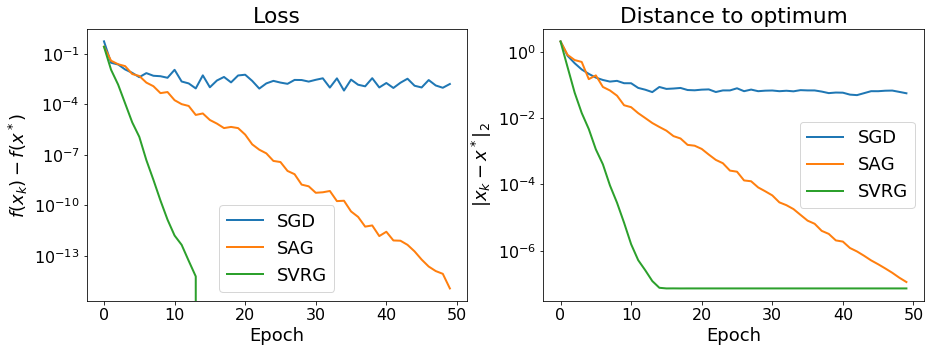

In [38]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

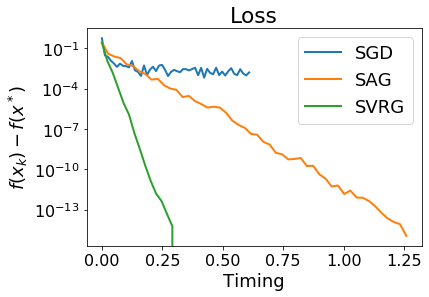

In [39]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q8) Compare the converge (on the different plots) of the stochastic methods you implemented

We can observe that the SVRG and the SAG methods converges to the optimum solution whereas the SGD method is not converging. After a short but sharp decrease, the loss of the SGD method stops decreasing and becomes constant.  
Both SVRG and SAG methods converge to the same optimum point (x_min). However, the optimum point is reached within 15 epochs for SVRG whereas, it takes 50 epochs for SAG. <br/>

The SAG and SVRG methods linearly converges to the optimum solution with log-scale with respect to the number of epochs (and with respect to time). This is due to the fact that for a given method the time to execute each epoch is constant.
The SGD method does not converge to the optimum solution when we choose a constant stepsize, even if for the very first epochs we have a significant loss decrease. The SGD method sublinearly converges to the optimum solution only if we choose a decreasing stepsize. 

The assumptions required for the linear convergence are the strong convexity which guarantees a simple lower bound and the smoothness which assures a simple upper bound. These two simples bounds constrain the loss function to linearly decrease.



<a id='comp'></a> 
## 5. Numerical comparison

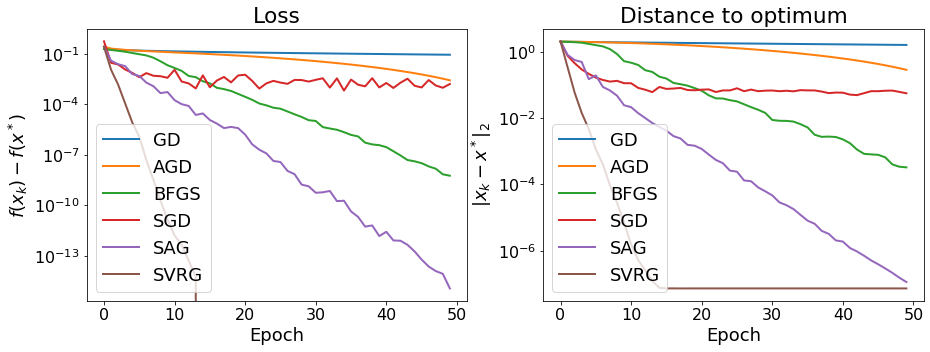

In [40]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

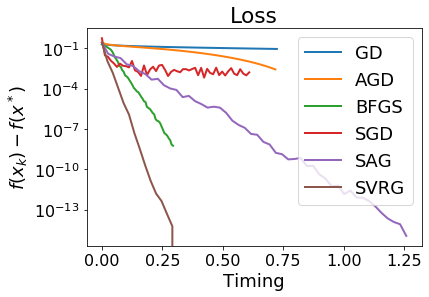

In [41]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:

For all the following questions, try to show only **FEW INFORMATIVE FIGURES** that highlight your conclusions.
- Q9) Compare the deterministic and the stochastic gradient methods. Comment your results.



- Q10) Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Q11) Look carefuly on how the data are generated in functions  ``simu_linreg`` and ``simu_logreg``. Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Q12) Change the number of data points $n$ and the number of data samples $d$ and compare your results. Comment.
- Q13) Conclude on the performance on the implemented methods. Are their "regimes" for which some methods are faster than others?
- Q14) Are there different behaviours between the deterministic methods? What about the stochastic ones?
- Q15) Compare the memory, the number of hyper-parameters to tune and the ease of implementation of each algorithm. According to this, in which configuration do you think a user should use deterministic method rather than a stochastic one, and vice-versa?

*ANSWERS:*

As the results are similar for linear and logistic regression models, then we are going to focus our interpretation on the linear regression model so as to avoid the redundancy of the explanation.

In [0]:
n_iter = 50
iis = np.random.randint(0, n, n * n_iter)

### Q9 : Comparison between the deterministic and the stochastic gradient methods

We can observe that the GD and AGD methods which are deterministic methods as well as the SGD method which is a stochastic method are less efficient than the BFGS (deterministic), the SAG and SVRG (stochastic) methods. <br/>
Let's analyze, for each of the Gradient Descent methods, the decrease of the loss with regards to the number of epochs (or the timing) as well as the decrease of the distance to the optimum solution in relation to the number of epochs. <br/>
We can see that the GD method with constant stepsize does not converge. Indeed, the loss is quasi constant along the epochs (the decrease of the loss is quasi null) and the distance to the optimum solution does not decrease either. The decrease of the loss of the GD method with constant stepsize is sublinear as the loss is not smooth, therefore it is not upper bounded. The GD method converges to the optimum solution if and only if the stepsize is decreasing. <br/>
The AGD method converges very slowly to the optimum solution. Indeed, we can observe that the decrease of the loss function with regards to the number of eppochs (or in relation to the time) as well as the decrease of the distance to the optimum solution are very slow. <br/>
Concerning the SGD method, the loss fastly decreases within the first 5th epochs but becomes quasi stationary with some instability from the 5th epoch. The decrease of the distance to the optimum is similar. Therefore, the SGD method converges far from the optimum solution. <br/>
The BFGS method is the more efficient deterministic method. Indeed, we can observe that the decrease of the loss as well as the decrease of the distance to the optimum solution is linear with regards to the number of epochs and the convergence of the method is very close to the optimum solution. If we compare the FBGS method to the SGD method, we can realize that the SGD method is more efficient within the first 20th epochs since the decrease of the loss as well as the decrease of the distance to the optimum are faster for the SGD method than for the FBGS method, nevertheless, after the 20th epoch the FBGS method continue decreasing until reaching a solution very close to the optimum point whereas the SGD method becomes stationary and remains very far from the optimum solution. <br/>
The SAG method is very efficient. Indeed, it is a bit less efficient than the SGD method within the first 10th epochs since the decrease of the loss as well as the decrease of the distance to the optimum are very fast for the SGD method until the 10the epoch. But the SAG method shows a linear decrease of the loss as well as a linear decrease of the distance to the optimum which expresses the fact that the loss of the SAG is smooth (upper bounded) and strongly convex (lower bounded). Moreover, the SAG method continue decreasing until reaching a point very close to the optimum solution. <br/>
Finally, the most efficient method is the SVRG method whose the loss as well as the distance to the optimum with regards to the number of epochs linearly decrease with a very high slope. Moreover, the SVRG method reaches the reach a convergence point which is very close to the optimum solution within 15 epochs. 

### Q10 : Influence of the regularization term on the convergence of the methods

In [0]:
def deterministic_gradient_solver (algo, loss, iis, grad_i, grad, n_iter, n, args=(), pgtol=1e-30, factr=1e-30):
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=args, pgtol=1e-30, factr=1e-30)
    
    if algo in ['gd','agd']:
        step = 1. / lipschitz_linreg(*args)
        if algo == 'gd':
            mon = monitor(gd, loss, x_min, args)
        else:
            mon = monitor(agd, loss, x_min, args)
        mon.run(x_init, grad, n_iter, step, args=args)
        
    elif algo == 'bfgs':
        mon = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, args)
        mon.run(loss, x_init, grad, maxiter=n_iter, args=args, pgtol=1e-30)
        
    return mon

############################################################################
              For lbda in 1/sqrt(n)
############################################################################


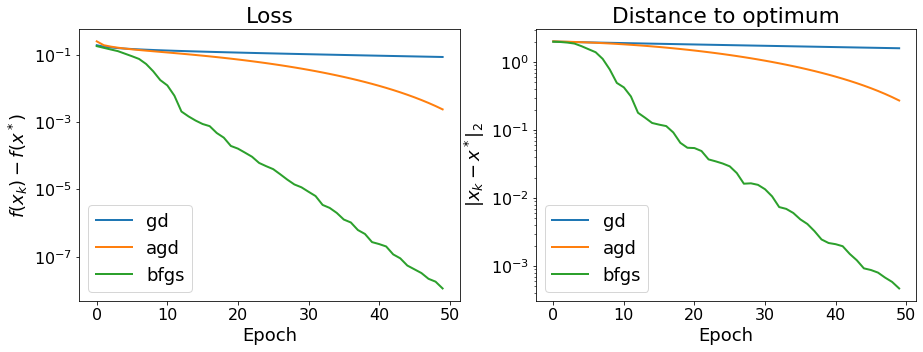

############################################################################
              For lbda in 1/n
############################################################################


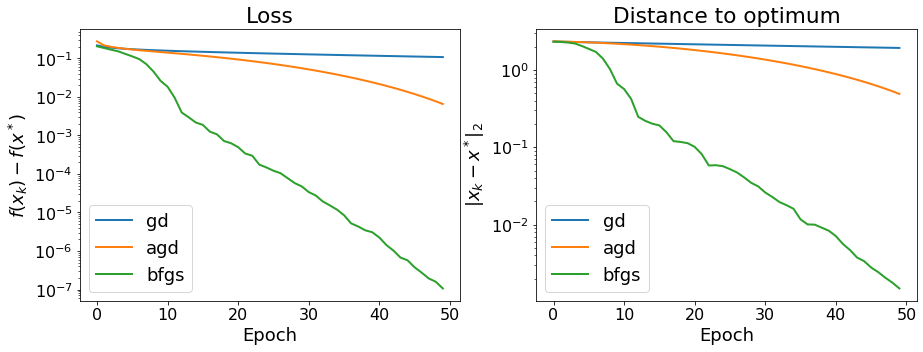

In [44]:
lbdas = [1./n**(1/2), 1./n]
solvers = ["gd", "agd", "bfgs"]
text = ["1/sqrt(n)", "1/n"]
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)

for i, lbda in enumerate(lbdas):
    monitor_lbda = []
    for algo in solvers: 
        args = (A, b, lbda)
        monitor_lbda.append(deterministic_gradient_solver (algo, loss, iis, grad_i, grad, n_iter, n, args=args, pgtol=1e-30, factr=1e-30))
    print("############################################################################")
    print("              For lbda in " + str(text[i]))
    print("############################################################################")
    plot_epochs(monitor_lbda, solvers)
    plt.show()  

In [0]:
def stochastic_gradient_solver (algo, loss, iis, grad_i, grad, n_iter, n, args=(), pgtol=1e-30, factr=1e-30):
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=args, pgtol=1e-30, factr=1e-30)
    
    if algo == 'sgd':
        step0 = 1e-1
        mon = monitor(sgd, loss, x_min, args)
        mon.run(x_init, iis, grad_i, n_iter * n, step0, args=args)
        
    elif algo == 'sag':
        max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
        step = 1.0 / (max_squared_sum + args[2])
        mon = monitor(sag, loss, x_min, args)
        mon.run(x_init, iis, grad_i, n_iter * n, step, args=args)
        
    elif algo == 'svrg':
        max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
        step = 1.0 / (max_squared_sum + args[2])
        mon = monitor(svrg, loss, x_min, args)
        mon.run(x_init, iis, grad, grad_i, n_iter * n, step, args=args)
        
    return mon

############################################################################
              For lbda in 1/sqrt(n)
############################################################################


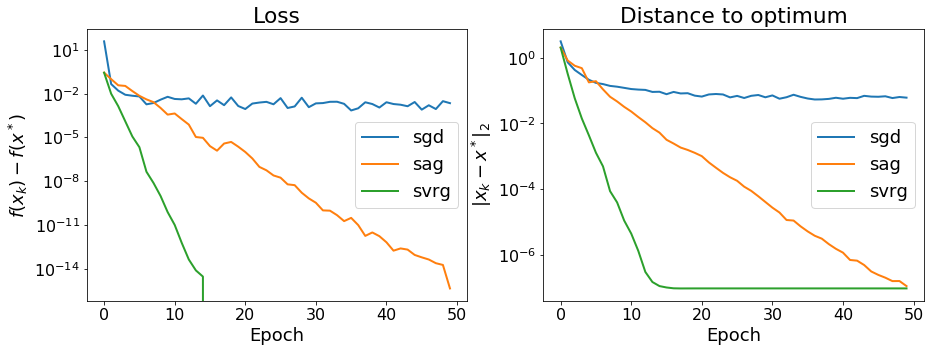

############################################################################
              For lbda in 1/n
############################################################################


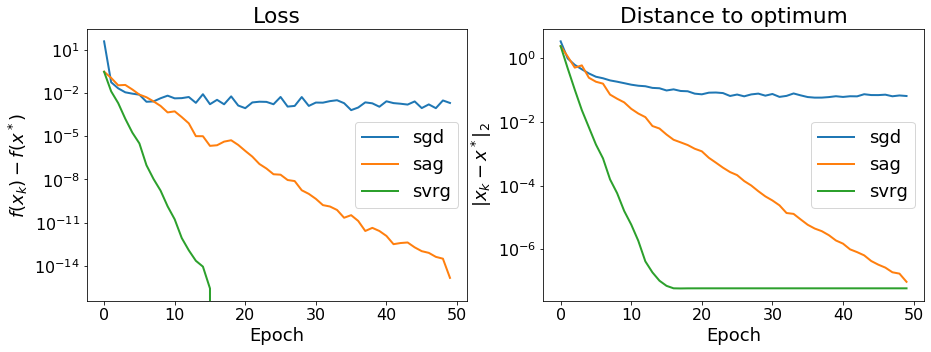

In [46]:
lbdas = [1./n**(1/2), 1./n]
solvers = ["sgd", "sag", "svrg"]
text = ["1/sqrt(n)", "1/n"]

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)

for i, lbda in enumerate(lbdas):
    monitor_lbda = []
    for algo in solvers: 
        args = (A, b, lbda)
        monitor_lbda.append(stochastic_gradient_solver(algo, loss, iis, grad_i, grad, n_iter, n, args=args))
    print("############################################################################")
    print("              For lbda in " + str(text[i]))
    print("############################################################################")
    plot_epochs(monitor_lbda, solvers)
    plt.show()  

In [0]:
def all_gradient_solver(algo, loss, iis, grad_i, grad, n_iter, n, args=(), pgtol=1e-30, factr=1e-30):
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=args, pgtol=1e-30, factr=1e-30)

    if algo in ['gd','agd']:
        step = 1. / lipschitz_linreg(*args)
        if algo == 'gd':
            mon = monitor(gd, loss, x_min, args)
        else:
            mon = monitor(agd, loss, x_min, args)
        mon.run(x_init, grad, n_iter, step, args=args)
        
    elif algo == 'bfgs':
        mon = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, args)
        mon.run(loss, x_init, grad, maxiter=n_iter, args=args, pgtol=1e-30)
        
    elif algo == 'sgd':
        step0 = 1e-1
        mon = monitor(sgd, loss, x_min, args)
        mon.run(x_init, iis, grad_i, n_iter * n, step0, args=args)
        
    elif algo == 'sag':
        max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
        step = 1.0 / (max_squared_sum + args[2])
        mon = monitor(sag, loss, x_min, args)
        mon.run(x_init, iis, grad_i, n_iter * n, step, args=args)
        
    elif algo == 'svrg':
        max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
        step = 1.0 / (max_squared_sum + args[2])
        mon = monitor(svrg, loss, x_min, args)
        mon.run(x_init, iis, grad, grad_i, n_iter * n, step, args=args)
        
    return mon

############################################################################
              For lbda in 1/sqrt(n)
############################################################################


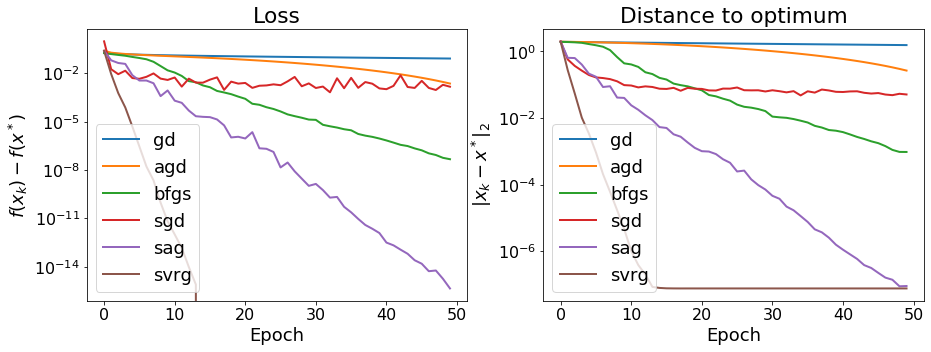

############################################################################
              For lbda in 1/n
############################################################################


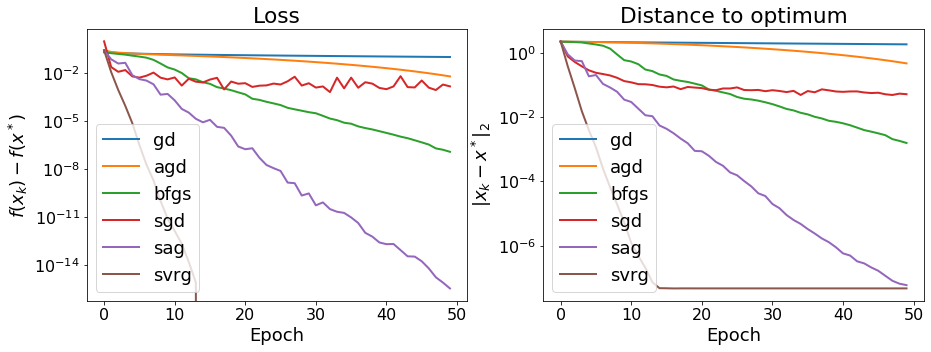

In [48]:
lbdas = [1./n**(1/2), 1./n]
solvers = ["gd", "agd", "bfgs", "sgd", "sag", "svrg"]
text = ["1/sqrt(n)", "1/n"]
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)

for i, lbda in enumerate(lbdas):
    monitor_lbda = []
    for algo in solvers: 
        args = (A, b, lbda)
        monitor_lbda.append(all_gradient_solver (algo, loss, iis, grad_i, grad, n_iter, n, args=args, pgtol=1e-30, factr=1e-30))
    print("############################################################################")
    print("              For lbda in " + str(text[i]))
    print("############################################################################")
    plot_epochs(monitor_lbda, solvers)
    plt.show()

We can realize that the higher is the regularization parameter the faster is the convergence of the optimization method to the optimum solution both for the full gradient methods and for the stochastic gradient methods. Conversely, the lower is the regularization parameter the slower is the convergence of the optimization method to the optimum solution. <br/>
How can we explain this phenomenon ? <br/>
The higher is the regularization parameter, the lower are the weights of the model (in some cases, some of the weights are equal to 0), therefore the lower is the number of weights to train and the faster is the convergence of the model. However, in this case, the optimum solution can be far from the true solution if the weights are too low : this is the underfitting phenomenon. <br/>
Conversely, the lower is the regularization parameter, the greater are the weights of the model (the less numerous are the weights which are equal to 0), therefore, the greater is the number of weights to train and the slower is the convergence of the model. Nevertheless, in this case, the optimum solution determined thanks to the optimization method is as close as possible to the true solution. But we have to be carefull about the overfitting phenomenon which leads to have very good performance on the training set but very bad performance in the generalization (on the cross-validation or on the testing sets). 

### Q11 : Influence of the correlations between the features on the convergence of the methods

In [0]:
def deterministic_gradient_solver (algo, loss, iis, grad_i, grad, n_iter, n, args=(), pgtol=1e-30, factr=1e-30):
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=args, pgtol=1e-30, factr=1e-30)

    if algo in ['gd','agd']:
        step = 1. / lipschitz_linreg(*args)
        if algo == 'gd':
            mon = monitor(gd, loss, x_min, args)
        else:
            mon = monitor(agd, loss, x_min, args)
        mon.run(x_init, grad, n_iter, step, args=args)
        
    elif algo == 'bfgs':
        mon = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, args)
        mon.run(loss, x_init, grad, maxiter=n_iter, args=args, pgtol=1e-30)
        
    return mon

############################################################################
              For correl = 0.1
############################################################################


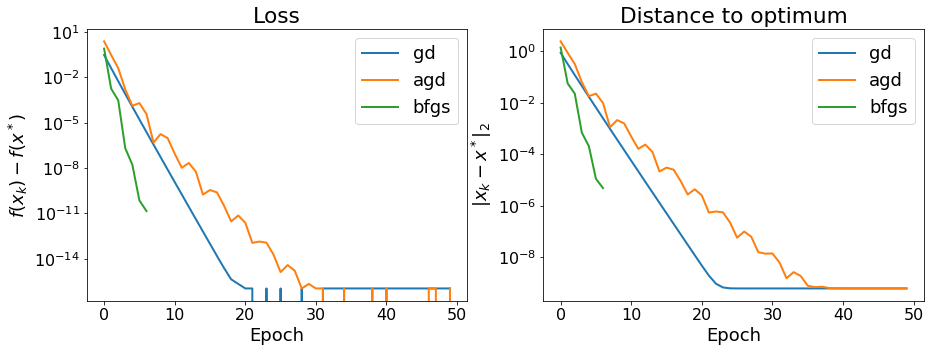

############################################################################
              For correl = 0.5
############################################################################


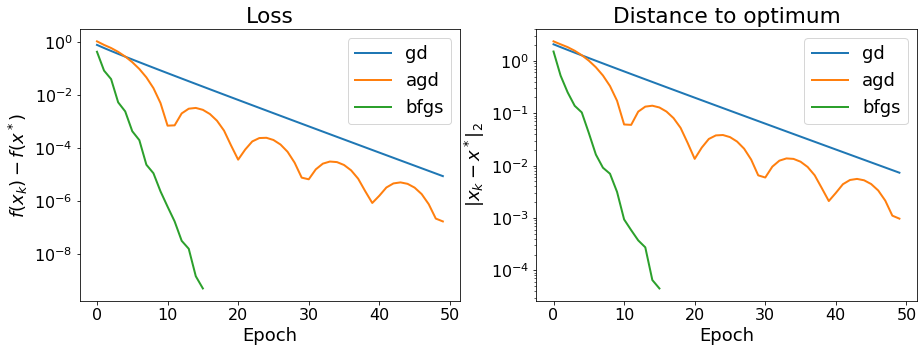

############################################################################
              For correl = 0.8
############################################################################


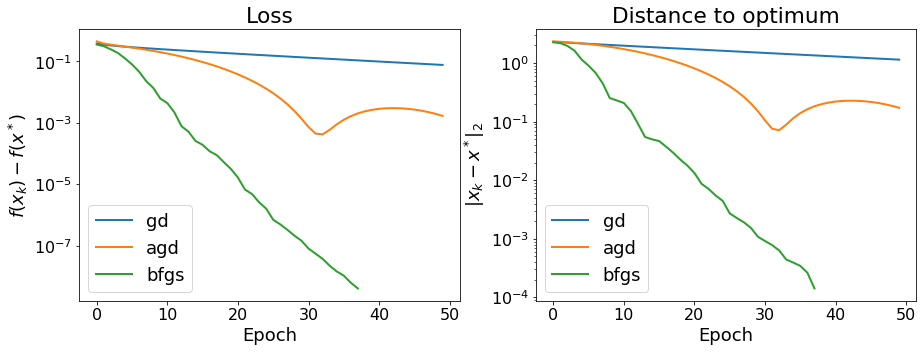

############################################################################
              For correl = 0.9
############################################################################


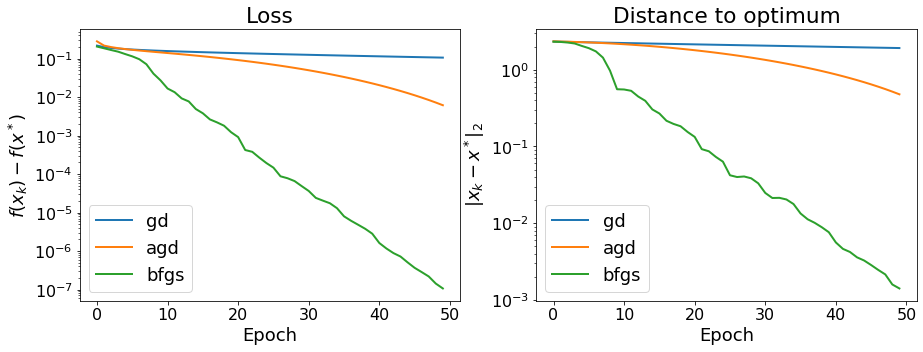

In [50]:
lbdas = 1./n**(1/2)
correlations = [0.1, 0.5, 0.8, 0.9]
solvers = ["gd", "agd", "bfgs"]
text = ["0.1", "0.5", "0.8", "0.9"]

for i, correl in enumerate(correlations):
    A, b = simu_linreg(x_model_truth, n, std=1., corr=correl)
    monitor_correl = []
    for algo in solvers: 
        args = (A, b, lbda)
        monitor_correl.append(deterministic_gradient_solver (algo, loss, iis, grad_i, grad, n_iter, n, args=args, pgtol=1e-30, factr=1e-30))
    print("############################################################################")
    print("              For correl = " + str(text[i]))
    print("############################################################################")
    plot_epochs(monitor_correl, solvers)
    plt.show()
        

In [0]:
def stochastic_gradient_solver (algo, loss, iis, grad_i, grad, n_iter, n, args=(), pgtol=1e-30, factr=1e-30):
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=args, pgtol=1e-30, factr=1e-30)
        
    if algo == 'sgd':
        step0 = 1e-1
        mon = monitor(sgd, loss, x_min, args)
        mon.run(x_init, iis, grad_i, n_iter * n, step0, args=args)
        
    elif algo == 'sag':
        max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
        step = 1.0 / (max_squared_sum + args[2])
        mon = monitor(sag, loss, x_min, args)
        mon.run(x_init, iis, grad_i, n_iter * n, step, args=args)
        
    elif algo == 'svrg':
        max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
        step = 1.0 / (max_squared_sum + args[2])
        mon = monitor(svrg, loss, x_min, args)
        mon.run(x_init, iis, grad, grad_i, n_iter*n, step, args=args)
        
    return mon

############################################################################
              For correl = 0.1
############################################################################


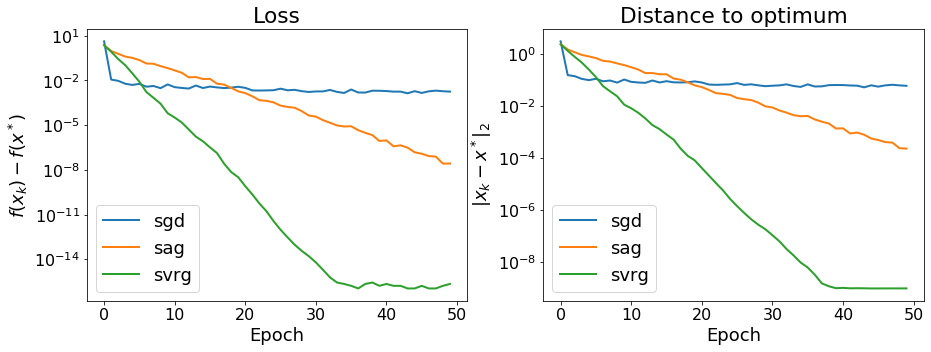

############################################################################
              For correl = 0.5
############################################################################


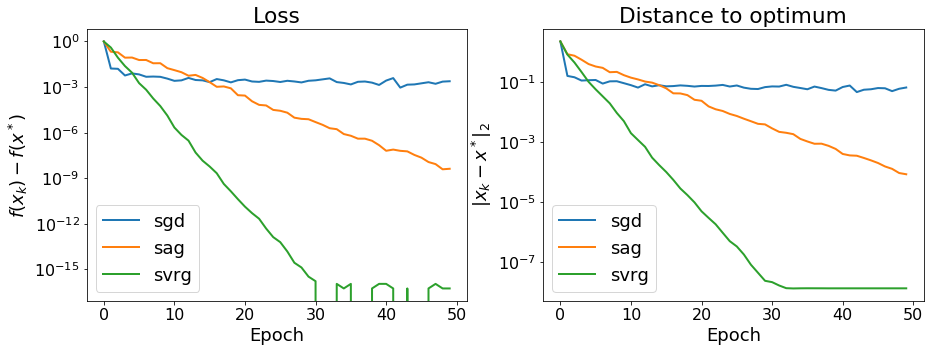

############################################################################
              For correl = 0.9
############################################################################


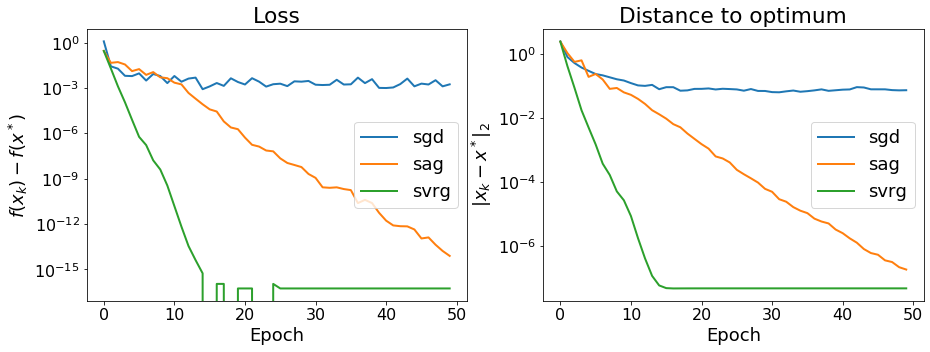

In [52]:
lbdas = 1./n**(1/2)
correlations = [0.1, 0.5, 0.9]
solvers = ["sgd", "sag", "svrg"]
text = ["0.1", "0.5", "0.9"]

for i, correl in enumerate(correlations):
    A, b = simu_linreg(x_model_truth, n, std=1., corr=correl)
    monitor_correl = []
    for algo in solvers: 
        args = (A, b, lbda)
        monitor_correl.append(stochastic_gradient_solver (algo, loss, iis, grad_i, grad, n_iter, n, args=args, pgtol=1e-30, factr=1e-30))
    print("############################################################################")
    print("              For correl = " + str(text[i]))
    print("############################################################################")
    plot_epochs(monitor_correl, solvers)
    plt.show()
        

In [0]:
def all_gradient_solver(algo, loss, iis, grad_i, grad, n_iter, n, args=(), pgtol=1e-30, factr=1e-30):
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=args, pgtol=1e-30, factr=1e-30)

    if algo in ['gd','agd']:
        step = 1. / lipschitz_linreg(*args)
        if algo == 'gd':
            mon = monitor(gd, loss, x_min, args)
        else:
            mon = monitor(agd, loss, x_min, args)
        mon.run(x_init, grad, n_iter, step, args=args)
        
    elif algo == 'bfgs':
        mon = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, args)
        mon.run(loss, x_init, grad, maxiter=n_iter, args=args, pgtol=1e-30)
        
    elif algo == 'sgd':
        step0 = 1e-1
        mon = monitor(sgd, loss, x_min, args)
        mon.run(x_init, iis, grad_i, n_iter * n, step0, args=args)
        
    elif algo == 'sag':
        max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
        step = 1.0 / (max_squared_sum + args[2])
        mon = monitor(sag, loss, x_min, args)
        mon.run(x_init, iis, grad_i, n_iter * n, step, args=args)
        
    elif algo == 'svrg':
        max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
        step = 1.0 / (max_squared_sum + args[2])
        mon = monitor(svrg, loss, x_min, args)
        mon.run(x_init, iis, grad, grad_i, n_iter*n, step, args=args)
        
    return mon

############################################################################
              For correl = 0.5
############################################################################


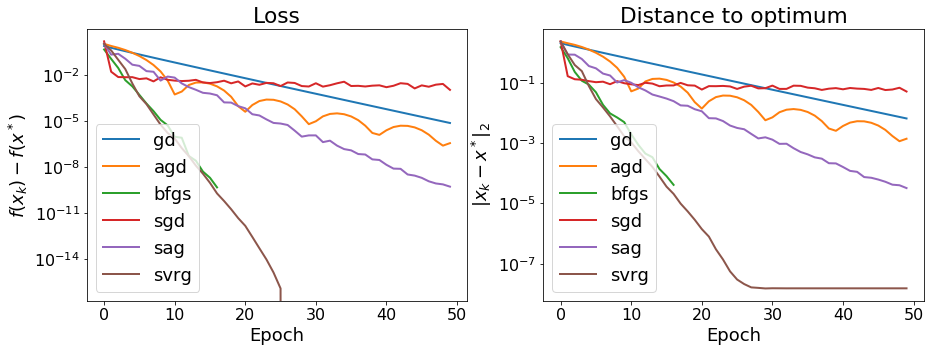

############################################################################
              For correl = 0.9
############################################################################


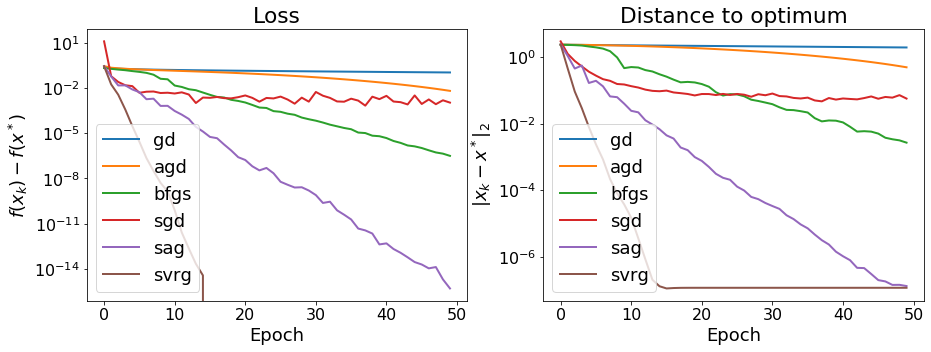

In [54]:
lbdas = 1./n**(1/2)
correlations = [0.5, 0.9]
solvers = ["gd", "agd", "bfgs", "sgd", "sag", "svrg"]
text = ["0.5", "0.9"]

for i, correl in enumerate(correlations):
    A, b = simu_linreg(x_model_truth, n, std=1., corr=correl)
    monitor_correl = []
    for algo in solvers: 
        args = (A, b, lbda)
        monitor_correl.append(all_gradient_solver (algo, loss, iis, grad_i, grad, n_iter, n, args=args, pgtol=1e-30, factr=1e-30))
    print("############################################################################")
    print("              For correl = " + str(text[i]))
    print("############################################################################")
    plot_epochs(monitor_correl, solvers)
    plt.show()
        

We can realize that the higher are the correlations between the features the lower are the values of the loss and the lower are the distances to the optimum solution. Moreover, the faster are the Gradient Descent methods both for the deterministic and the stochastic methods. Once again, we can observe that the GD method with a constant stepsize does not converge to the optimum solution. The convergence of the AGD algorithm is very slow. The decrease of the loss corresponding to the SGD method is very unstable but becomes quickly stationary. Indeed within less than 10 epochs we can see that the convergence final value is reached. Concerning the decrease of the distance to the optimum for the SGD method, it decreases very smoothly but in the same way as previously, the decrease becomes stationary within 10 epochs and the final value remains far from the optimum solution. The convergence of the SAG method looks like to the one of the SGD method except the fact that the decrease of the SAG method is more smooth than the one of the SGD method and conversely, the decrease of the distance to the optimum solution for the SAG method is unstable at the beginning and also becomes stationary within 10 epochs. \\
We can observe that the loss of the BFGS method decreases slower than the stochastic methods on the 15 first epochs however after that the stochastic methods (SGD and SAG) becomes stationary whereas the BFGS method continues decreasing. Moreover, the decrease of the distance to the optimum solution is also slower at the beginning (until the 15th epoch) but after that the two stochastic methods stop decreasing whereas the BFGS method continue decreasing until reaching the otpimum solution. \\
How can we explain that the higher is the correlation between the features, the more efficient are the Gradient Descent Methods ? \\
Let assume in a first time that all the features are independent from each other. This means that each of the d features is really important to explain the variation of the data. And the information held by the d features can not be reduced on a smaller number of features. \\
Now let assume that there are some (linear) correlations between the features. This implies that the data, explained by the d correlated features, line up on the directions of the linear combinations of the most correlated features which correspond to the directions of the correlations that are the most important. In this case, we are able to build new features in a new latent space which are able to explain the most part of the information initially explained by the d original features. This change of representation space is called PCA. Thanks to PCA we are able to find the Principal Components (linear combinations of the d original features) which retain the most part of the information and thus to shrink the dimensionality of the features which explain the data. \\
Therefore, when the features are correlated, as we are able to explain the most part of the variation of the data thanks to a small number of new variables (PCs) thus, the Gradient Descent Algorithm has less parameters to learn and to update that is the reason why the convergence of the methods is faster. \\

Specifically, we can observe some changes of behaviours when modify the correlations between the features of the model. Indeed, concerning the deterministic methods, we can realize that the BFGS method always presents better performances than the two other methods whereas the GD and the AGD methods present some difference of behaviours in function of the degree of correlations between the features. For very low correlations, we can see that the GD method is more efficient than the AGD method : the decrease of the loss function and the decrease of the distance to the optimum solution with regards to the number of epochs is faster for the GD method. However, when we increase the importance of the correlations between the features of the model, we can see that the AGD method becomes more efficient than the GD method. \\
Furthermore, we can realize that the lower is the degree of the correlations between the features of the model, the more unstable is the AGD method, conversely, the higher are the correlations between the features of the model, the more smooth is the decrease of the loss for the AGD method. This can be explained by the fact that the higher are the correlations between the features, the more important is the redundancy of the information that we have in order to learn the parameters, thus the more stable is the model.

### Q12 : Influence of the number of the number of points n and the number of features d on the convergence of the methods.

In [0]:
def all_gradient_solver(algo, loss, iis, grad_i, grad, n_iter, n, args=(), pgtol=1e-30, factr=1e-30):
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=args, pgtol=1e-30, factr=1e-30)

    if algo in ['gd','agd']:
        step = 1. / lipschitz_linreg(*args)
        if algo == 'gd':
            mon = monitor(gd, loss, x_min, args)
        else:
            mon = monitor(agd, loss, x_min, args)
        mon.run(x_init, grad, n_iter, step, args=args)
        
    elif algo == 'bfgs':
        mon = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, args)
        mon.run(loss, x_init, grad, maxiter=n_iter, args=args, pgtol=1e-30)
        
    elif algo == 'sgd':
        step0 = 1e-1
        mon = monitor(sgd, loss, x_min, args)
        mon.run(x_init, iis, grad_i, n_iter * n, step0, args=args)
        
    elif algo == 'sag':
        max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
        step = 1.0 / (max_squared_sum + args[2])
        mon = monitor(sag, loss, x_min, args)
        mon.run(x_init, iis, grad_i, n_iter * n, step, args=args)
        
    elif algo == 'svrg':
        max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
        step = 1.0 / (max_squared_sum + args[2])
        mon = monitor(svrg, loss, x_min, args)
        mon.run(x_init, iis, grad, grad_i, n_iter*n, step, args=args)
        
    return mon

In [0]:
d = 50
list_n = [50, 100, 1000, 5000, 10000]
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

# _A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

In [57]:
correlation = 0.9
solvers = ["gd", "agd", "bfgs", "sgd", "sag", "svrg"]
text = ["50", "100", "1000", "5000", "10000"]

for i, num in enumerate(list_n):
    lbdas = 1./num**(1/2)
    A, b = simu_linreg(x_model_truth, num, std=1., corr=correlation)
    monitor_num = []
    for algo in solvers: 
        args = (A, b, lbda)
        monitor_num.append(all_gradient_solver(algo, loss, iis, grad_i, grad, n_iter, num, args=args, pgtol=1e-30, factr=1e-30))
    print("############################################################################")
    print("              For n = " + str(text[i]))
    print("############################################################################")
    plot_epochs(monitor_num, solvers)
    plt.show()
        

ValueError: ignored

In [0]:
list_d = [10, 50, 100, 1000]
n = 10000

# _A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

In [0]:
correlations = 0.9
lbdas = 1./n**(1/2)
solvers = ["gd", "agd", "bfgs", "sgd", "sag", "svrg"]
text = ["10", "50", "100", "1000"]

for i, feat in enumerate(list_d):
    d = feat
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)
    idx = np.arange(d)
    # Ground truth coefficients of the model
    x_model_truth = (-1)**idx * np.exp(-idx / 10.)
    A, b = simu_linreg(x_model_truth, n, std=1., corr=correl)
    monitor_feat = []
    for algo in solvers: 
        args = (A, b, lbda)
        monitor_feat.append(all_gradient_solver (algo, loss, iis, grad_i, grad, n_iter, n, args=args, pgtol=1e-30, factr=1e-30))
    print("############################################################################")
    print("              For d = " + str(text[i]))
    print("############################################################################")
    plot_epochs(monitor_feat, solvers)
    plt.show()
        

### For n >> d 
We can observe that the greater is the number of samples taken into account in the training of the methods, the lower is the loss as well as the distance to the optimum solution and the faster is the convergence of the methods. However, we have to be carefull about some issues. Indeed, if the number of samples is really big with regards to the number of features, this can lead to the underfitting phenomenon with a high bias since the model trie to minimize for each sample the error term between the predicted label and the ground truth label, thus the model is very rough. In this case the performance will be bad both on the training and the testing sets. 

### For n << d 
We can realize that we obtain very bad results. Indeed, in the case where the number of samples n is very low with regards to the number of features, this leads to the overfitting phenomenon with a high variance. On the training set, the model tries to fit as much samples as possible in a very accurate way. Therefore, the model is very accurate on the training set what minimizes for each sample the error term between the predicted label and the ground truth label. However, when we want to generalize the model to predict new samples which do not belong to the training set (testing set or cross-validation set) we can observe very bad performance as the model that we have trained is too close to the samples of the training set. 

### For n $\simeq$ d 
We can realize that we obtain good performances. Indeed, when we have a number of observations of the same order of magnitude as the number of features, this enables us to control the trade off between the underfitting phenomenon with high bias issue and the overfitting phenomenon with high variance issue. 

### Q13 : Conclude on the performance on the implemented methods. Are their "regimes" for which some methods are faster than others?

For this purpose, we have implemented three deterministic (batch) methods which are Gradient Descent (GD), Accelerated Gradient Descent (AGD) and L-BFGS and three stochastic methods which are Stochastic Gradient Descent (SGD), Stochastic Average Gradient (SAG) and Stochastic Variance Reduced Method Gradient (SVRG). <br/>
Firstly, GD and SGD are the worse methods implemented here: GD does not converge and AGD converge at a very slow pace.<br/>
Secondly, SGD stops converging after a few iterations because of the constant stepsize. However, it appears that it is a simple method to get an approximation of the minimum in only a few iterations. <br/>
Thirdly, SVRG seems to be the best method as it converges extremlly fast compared to the others methods (15 iterations) and reaches a point very close to the minimum (x_min) (less that 10^-6).<br/>


### Q14 : Are there different behaviours between the deterministic methods? What about the stochastic ones?

Concerning the deterministic methods, we have to distinguish two main behaviours. <br/>
On the one hand, we can observe that the GD and the AGD methods have very similar behaviours. Indeed, the decrease of the loss function as well as the decrease of the distance to the optimum solution for the GD method with constant stepsize are quasi null what means that the GD method with constant stepsize does not converge to the optimum solution. However this method slowly converges to the optimum solution if we choose a decreasing stepsize instead of the constant stepsize. And for the AGD method the decrease of the loss function as well as the decrease of the distance to the optimum solution decreases very slowly and reaches a point of convergence which remains very far from the optimum solution. For these two methods we can say that the decrease of the loss function with regards to the number of epochs according to a log scale is sublinear since the loss functions are not upper bounded (smoothness assumption). <br/>
On the other hand, we can observe the BFGS method which present a very different behaviour from the two previous methods. Indeed, we can realize that the decrease of the loss function as well as the decrease of the distance to the optimum, in relation to the number of epochs, according to a log scale, is linear what means that the loss function of the BFGS method satisfies the assumptions of strong convexity and smoothness which enable respectively to lower bound and upper bound the loss function. Moreover, the BFGS method reaches a convergence point which is very close to the optimum solution. <br/>

Concerning the stochastic methods, we can realize that unlike the deterministic methods, we cannot distinguish very distinct behaviours between the different methods. Indeed, we can realize that for both the SGD, the SAG and the SVRG methods, the behaviours of the loss functions and the progression of the distance to the optimum solution are very similar. We can observe that the loss function as well as the distance to the optimum solution decrease very fast at the beginning until a number of epochs between 5 and 10 and after 10 epochs they reach a stationary regime and do not decrease any more, remaining far from the optimum solution. Nevertheless, we can observe that the SVRG method is the more smooth method that is the one which does not suffer from noise produced by high variance phenomenon. Unlike the SVRG method, the SGD and SAG methods present some noisy iterates. Therefore, the SVRG is the more powerful stochastic method even if it is a bit expensive from a computational point of view.

### Q15 : Compare the memory, the number of hyper-parameters to tune and the ease of implementation of each algorithm. According to this, in which configuration do you think a user should use deterministic method rather than a stochastic one, and vice-versa?

The GD method does not require to tune many hyper-parameters. However the deterministic GD method requires computing a gradient for each data point what is very expensive and slow down in an important way the gradient descent algorithm. <br/>

In order to improve the efficiency of the GD method, we have decided to develop the SGD method which is based on the following assumption : the stochastic gradient is an unbiased estimator of the full gradient. Therefore, for the SGD method, instead of computing the full gradient at each iteration, we only compute an unbiased estimator of the full gradient at each iteration which corresponds to the gradient computed in only one point uniformly drawn in the samples space. Moreover, this method does not require to compute additional hyper-parameter. However, this method suffers from noisy iterates due to a high variance issue. In order to solve this problem we can use the SGDA method which averages the iterates giving a more smooth function. However averaging a large number of iterates is not so efficient that is the reason why we prefer only averaging the last iterates to give a function more smooth towards the convergence point. <br/>


There exist several variance reduced methods such as SAGA, SVRG and so on. We have chosen only to implement the SVRG method. What are the advantages and the drawbacks of the variance reduced methods from a point of view of the memory ? <br/>
Variance reduced methods use only one stochastic gradient per iteration and converge linearly on strongly convex function. We can choose fixed stepsize and the convergence is always insured. The SVRG method only has a complexity in O(d), that is O(d) storage. However, this method requires full gradient computations every so often what can slow down the gradient descent process. Moreover, this method has an extra number of inner iterations parameter to tune. <br/>

In the case where we have a dataset composed of a large number of samples and that the necessity of having a very accurate solution is not so important, I would prefer using the stochastic methods which are much faster and less expensive than the deterministic from a computational point of view. However when we want to obtain the optimum solution of the algorithm in a very accurate way, even if it is more expensive from a computational point of view, I would prever the deterministic methods on a very large number of iteration. 